# **Segmentation**
Experiment 2

Dataset:ORIGA&RIM-ONE DL

In [ ]:
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Install necessary packages
!pip install tensorflow==2.12
!pip install keras==2.12
!pip install -U segmentation-models

In [ ]:
#Import necessary libraries
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras

In [ ]:
import segmentation_models as sm

In [ ]:

import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
'''
# Function to apply denoising to an image using either a Gaussian filter or a median filter
def denoise_image(image, filter_type='gaussian', filter_size=3):
    if filter_type == 'gaussian':
        denoised_image = cv2.GaussianBlur(image, (filter_size, filter_size), 0)
    elif filter_type == 'median':
        denoised_image = cv2.medianBlur(image, filter_size)
    else:
        raise ValueError("Invalid filter_type. Choose 'gaussian' or 'median'.")

    return denoised_image

'''

In [ ]:
#Resizing images, if needed

SIZE_X = 128
SIZE_Y = 128

n_classes=3 #Number of classes for segmentation
num_images = 2040  #Total 680 available //augmentation v1 1360 // V2 - 2040

In [ ]:
# Load image and mask names
image_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/ORIGA&RIMONEDL_after_augmentation_version_2/Images/*.png")
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(image, 1) for image in image_names_subset] #SM backbones use 3 channel images, so let us read images in color.

In [ ]:
#Convert the list of  images to a numpy array
image_dataset = np.array(images)

In [ ]:
mask_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/ORIGA&RIMONEDL_after_augmentation_version_2/Masks/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]

In [ ]:
#Convert the list of masks to a numpy array
mask_dataset = np.array(masks)

In [ ]:
# Print some information about the dataset
print("Total images in the original dataset are: ", len(image_names))
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Total images in the original dataset are:  2040
Image data shape is:  (2040, 128, 128, 3)
Mask data shape is:  (2040, 128, 128)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2]


In [ ]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2])

In [ ]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)


(2040, 128, 128, 1)


In [ ]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [ ]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
print(y_train_cat.shape)

(1632, 128, 128, 3)


In [ ]:
#Reused parameters in all models
import tensorflow
n_classes=3
activation='softmax'

LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
###Model
BACKBONE = 'resnet34'
#BACKBONE = 'resnet50'
#BACKBONE = 'vgg19'
#BACKBONE = 'efficientnetb0'
#BACKBONE = 'densenet121'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_processed = preprocess_input(X_train)
X_test_processed = preprocess_input(X_test)

In [ ]:
#images
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics=metrics)

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [ ]:
#batch_size= 16
#epochs=50,
#Resnet34
#ORIGA & RIM ONE DL
#With augmentation_ v2_ 2040 , without denoising

# Train the model
history=model.fit(X_train_processed,
          y_train_cat,
          batch_size=16,
          epochs=50,
          verbose=1,
          validation_data=(X_test_processed, y_test_cat))


Epoch 1/50
102/102 [==============================] - 40s 109ms/step - loss: 0.3210 - iou_score: 0.6741 - f1-score: 0.7797 - val_loss: 0.4727 - val_iou_score: 0.5227 - val_f1-score: 0.6849
Epoch 2/50
102/102 [==============================] - 9s 91ms/step - loss: 0.1124 - iou_score: 0.8816 - f1-score: 0.9367 - val_loss: 0.5683 - val_iou_score: 0.3939 - val_f1-score: 0.5419
Epoch 3/50
102/102 [==============================] - 9s 91ms/step - loss: 0.0788 - iou_score: 0.9096 - f1-score: 0.9524 - val_loss: 0.6843 - val_iou_score: 0.3536 - val_f1-score: 0.4598
Epoch 4/50
102/102 [==============================] - 9s 93ms/step - loss: 0.0634 - iou_score: 0.9228 - f1-score: 0.9597 - val_loss: 0.7140 - val_iou_score: 0.3224 - val_f1-score: 0.4339
Epoch 5/50
102/102 [==============================] - 10s 94ms/step - loss: 0.0550 - iou_score: 0.9304 - f1-score: 0.9638 - val_loss: 0.7071 - val_iou_score: 0.3253 - val_f1-score: 0.4407
Epoch 6/50
102/102 [==============================] - 10s 95ms

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/Saved_model/Segmentation_UNET_Resnet34_ORIGA&RIMONEDL_with_Aug_V2_2040_without_denoising_Epoch_50_batch_16.hdf5')

In [ ]:
import pickle

# Save the history as a pickle file
with open('/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/Saved_history/Segmentation_UNET_Resnet34_ORIGA&RIMONEDL_with_Aug_V2_2040_without_denoising_Epoch_50_batch_16_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

### FOR NOW LET US FOCUS ON A SINGLE MODEL

#Set compile=False as we are not loading it for training, only for prediction.
model = load_model('/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/Saved_model/Segmentation_UNET_Resnet34_ORIGA&RIMONEDL_with_Aug_V2_2040_without_denoising_Epoch_50_batch_16.hdf5', compile=False)

In [ ]:
#IOU
from keras.metrics import MeanIoU
y_pred=model.predict(X_test_processed)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [ ]:
#mIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.98035127


In [ ]:

#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)

#



[[1.872281e+06 1.600400e+04 4.000000e+00]
 [2.069800e+04 2.594922e+06 1.101100e+04]
 [0.000000e+00 2.007900e+04 2.149673e+06]]
IoU for class1 is:  0.980772
IoU for class2 is:  0.97454023
IoU for class3 is:  0.98574173


In [ ]:
# Import the random library
import random
# Generate a random index for the test dataset
img_number = random.randint(0, len(X_test_processed)-1)
# Get the image, mask, and prediction at the randomly generated index
img = X_test_processed[img_number]
mask = y_test[img_number]
prediction = y_pred_argmax[img_number]

# Create a new figure with a specified size
plt.figure(figsize=(12, 8))
# Create a subplot for the image
plt.subplot(231)
plt.title('Image')
plt.imshow(img, cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask[:,:,0])
# Create a subplot for the prediction
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction)
# Show the figure
plt.show()

# **To test the model on the HRF datast**

1/1 [==============================] - 1s 775ms/step


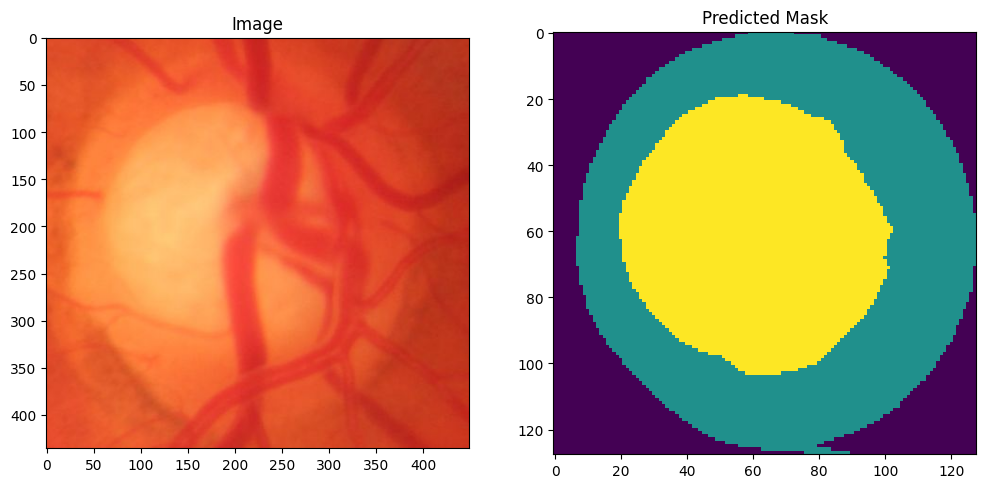

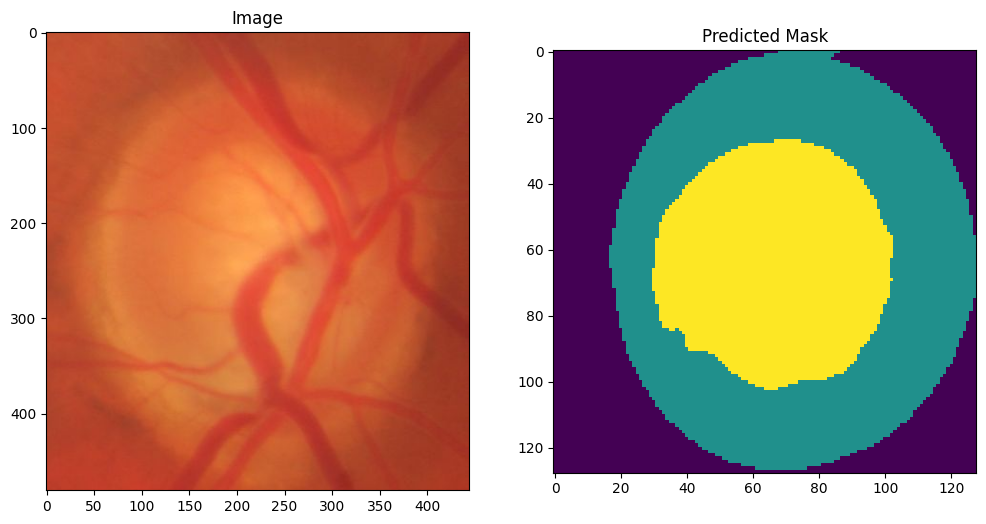

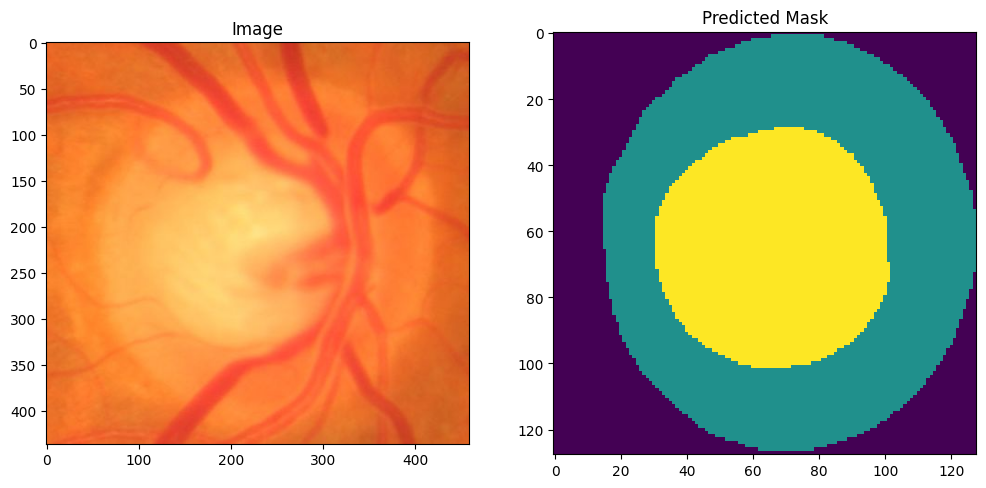

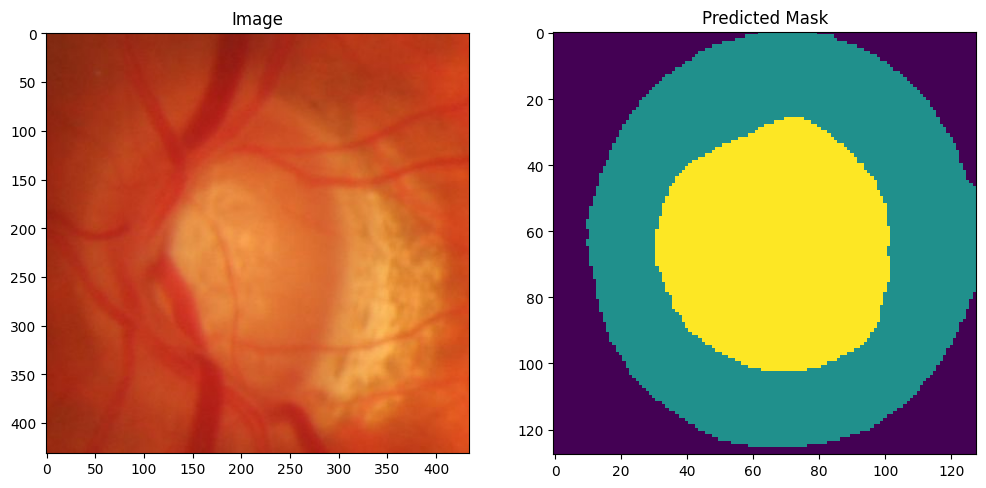

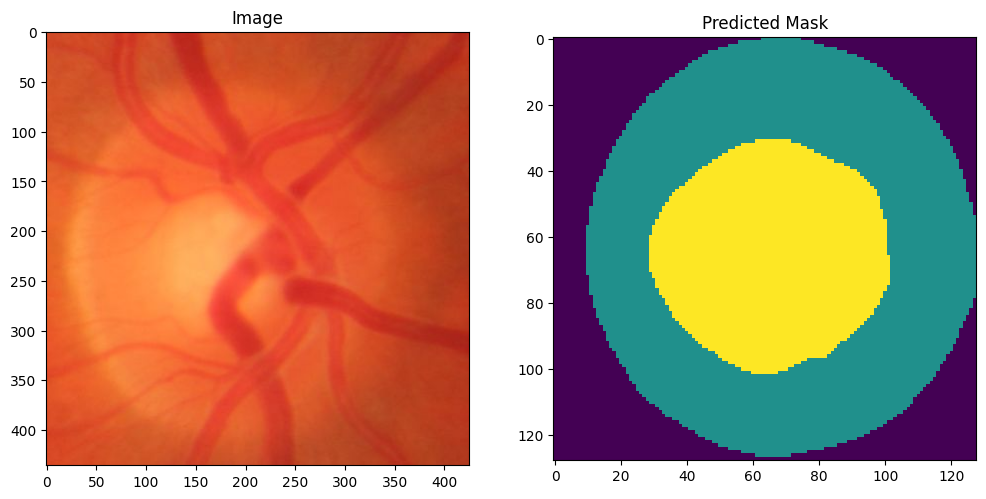

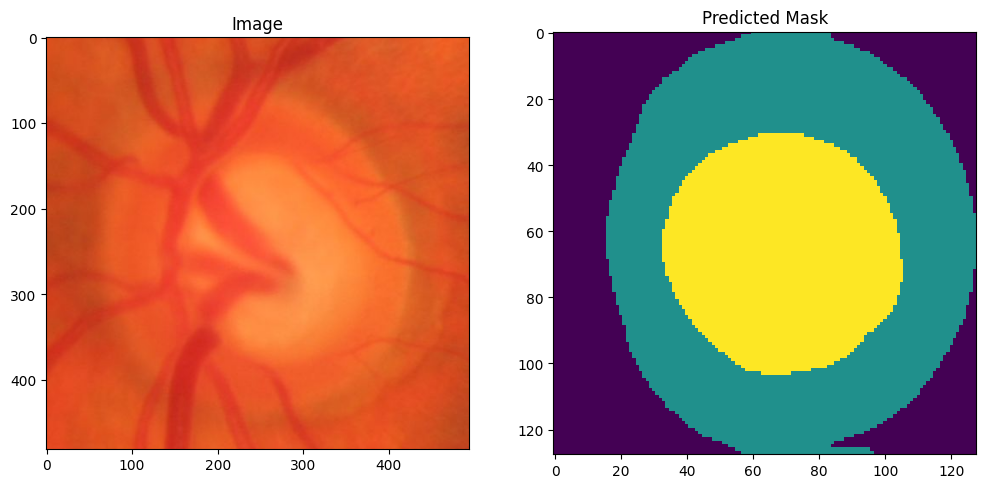

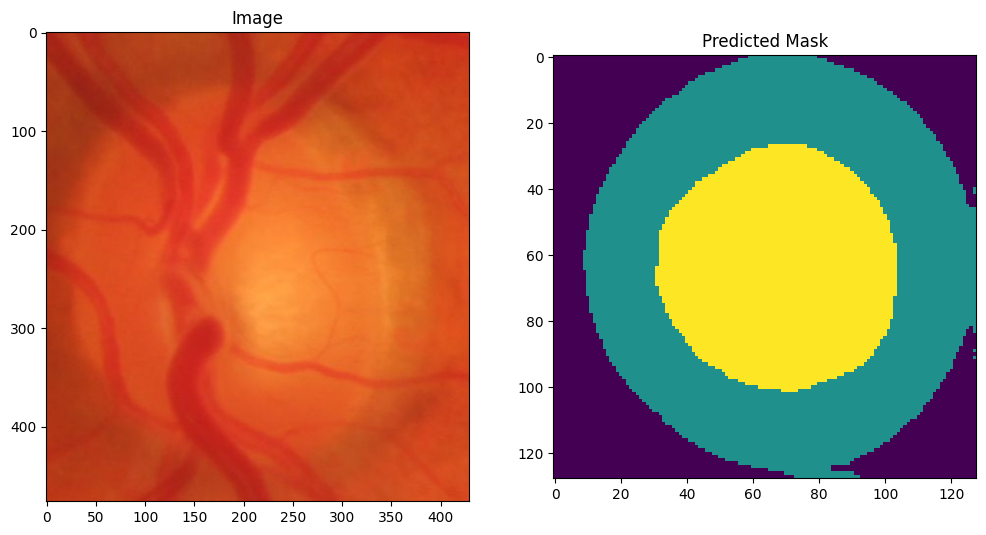

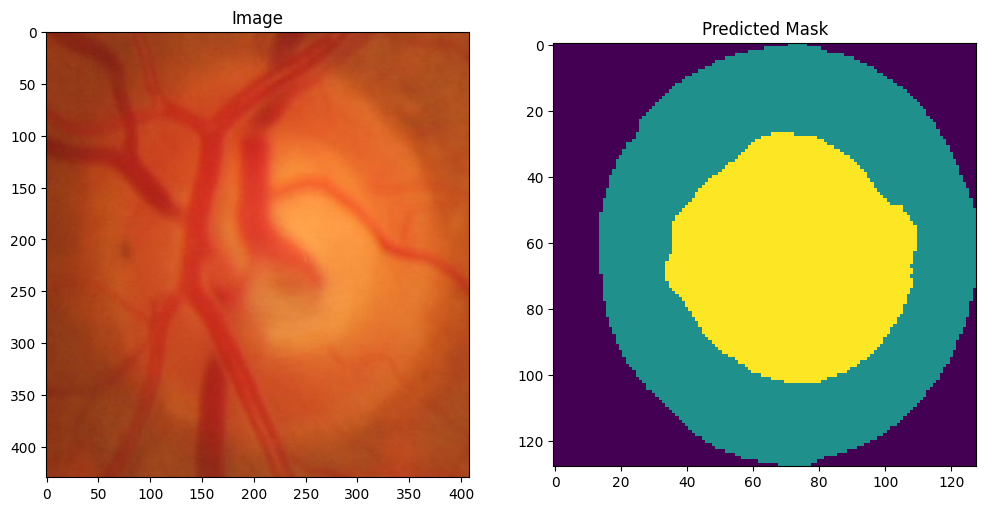

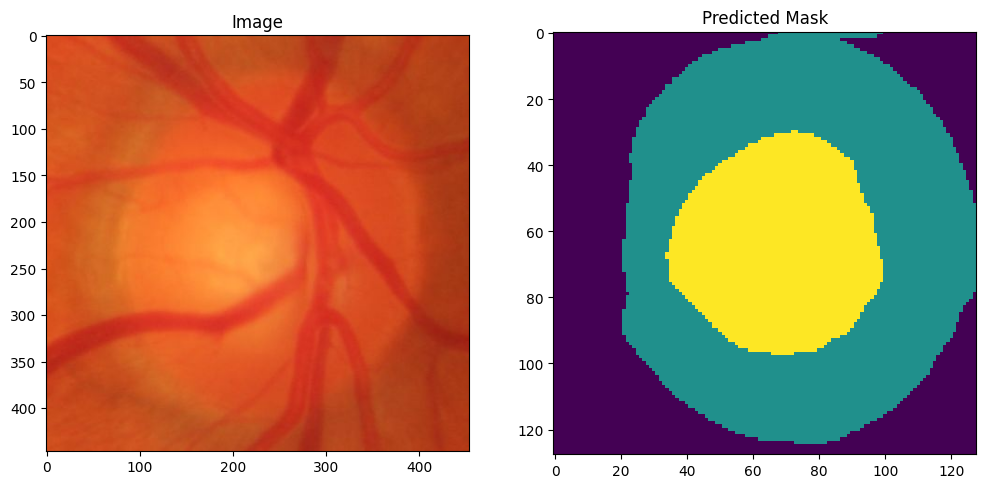

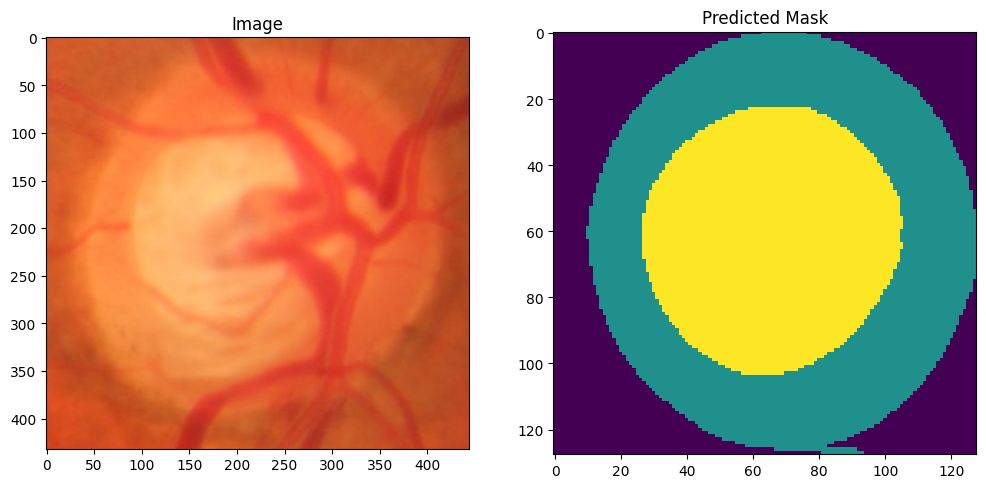

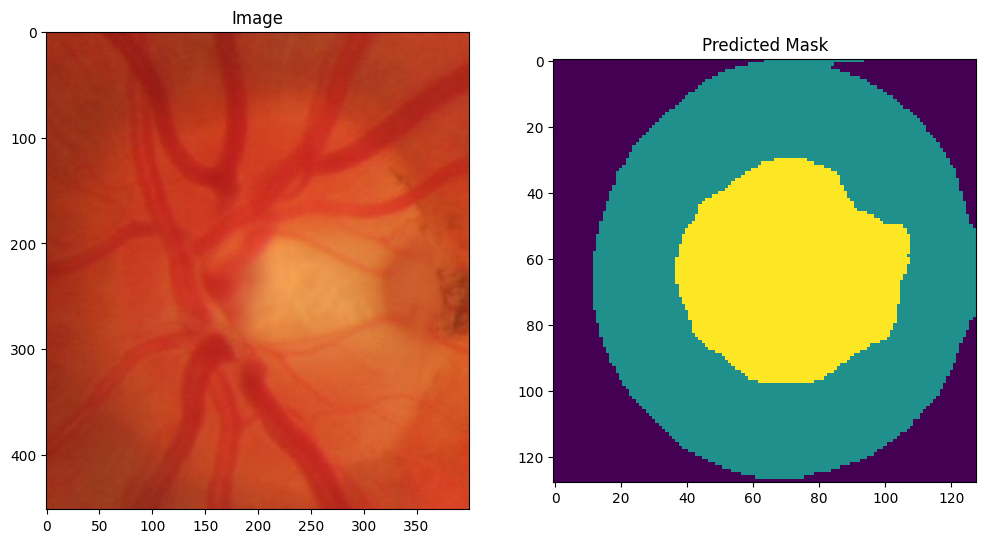

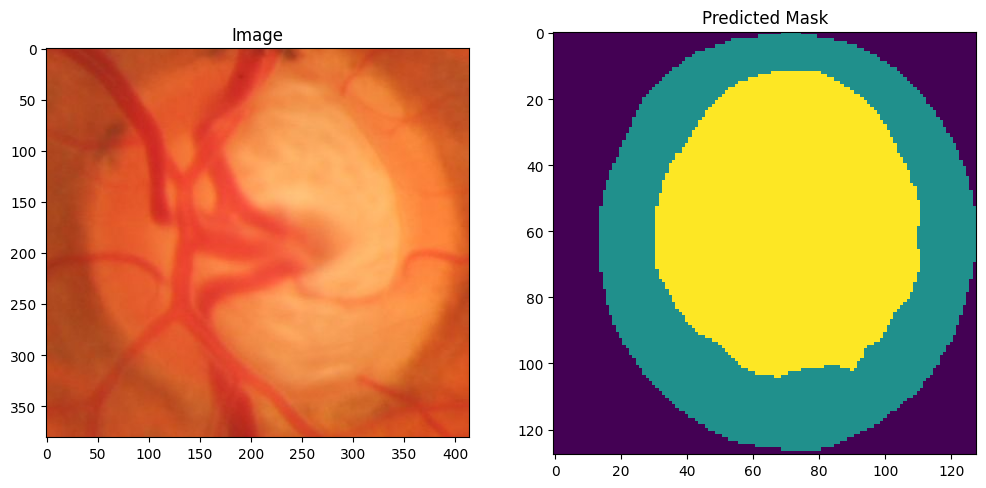

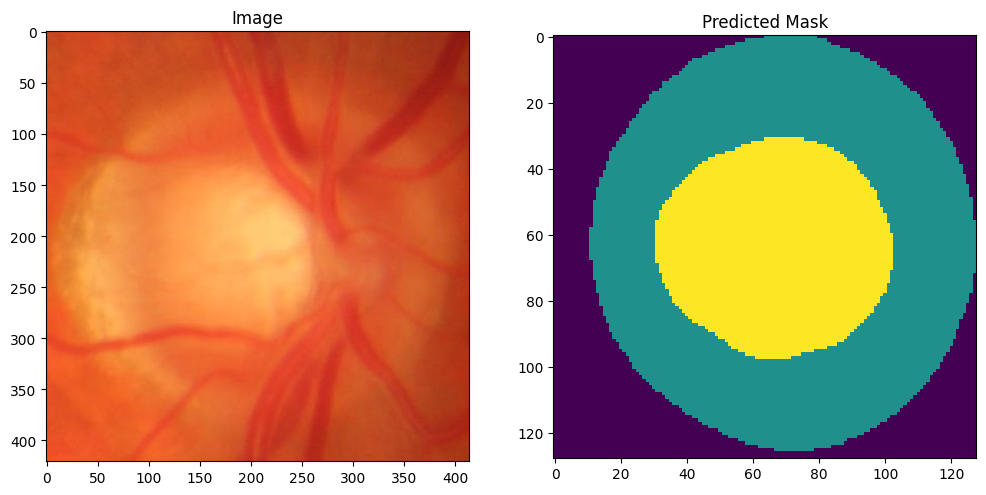

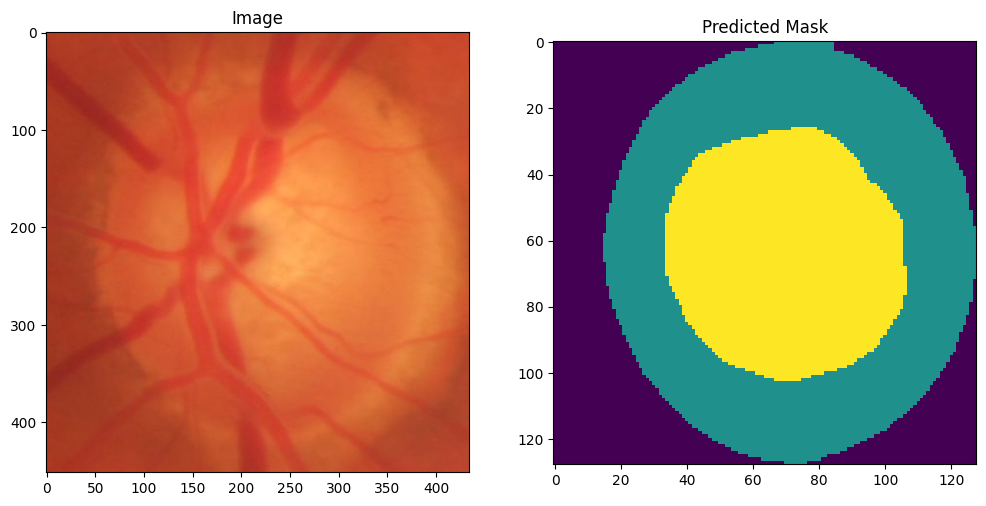

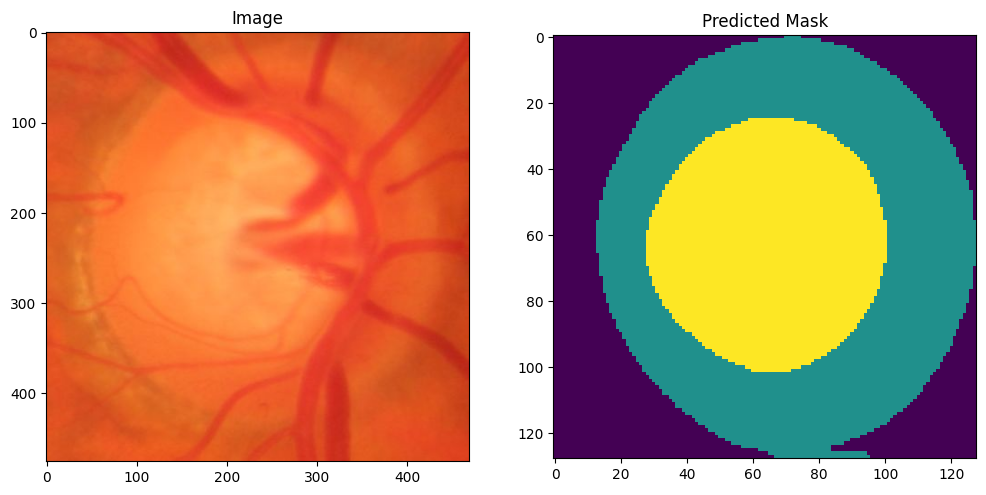

In [ ]:
# Import necessary libraries
from keras.models import load_model
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the trained model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/Saved_model/Segmentation_UNET_Resnet34_ORIGA&RIMONEDL_with_Aug_V2_2040_without_denoising_Epoch_50_batch_16.hdf5', compile=False)

# Load the new dataset
new_image_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/Project Implementation/HRF_Data cleaning/HRF_Cropped/glaucoma/*.jpg")
new_images = [cv2.imread(image, 1) for image in new_image_names]

# Apply resize
new_width = 128
new_height = 128
dim = (new_width, new_height)
resized_images = [cv2.resize(image, dim, interpolation=cv2.INTER_AREA) for image in new_images]

# Preprocess the new images
new_image_dataset = np.array(resized_images)
new_image_dataset = new_image_dataset / 255.

# Make predictions on the new dataset
new_predictions = model.predict(new_image_dataset)
new_predictions_argmax = np.argmax(new_predictions, axis=3)

# Save the predicted masks with the same name as the original images
output_path = "/content/drive/MyDrive/Colab Notebooks/Project Implementation/HRF_Data cleaning/HRF_after_segmentation/glaucoma/"
for i, prediction in enumerate(new_predictions_argmax):
    image_name = os.path.basename(new_image_names[i])
    mask_name = os.path.splitext(image_name)[0] + "_mask.png"
    #cv2.imwrite(output_path + mask_name, prediction)

# Visualize some images with their corresponding masks
num_images_to_visualize = 15
for i in range(num_images_to_visualize):
    plt.figure(figsize=(12, 8))
    plt.subplot(121)
    plt.title('Image')
    plt.imshow(cv2.cvtColor(new_images[i],cv2.COLOR_BGR2RGB)) #I add here
    plt.subplot(122)
    plt.title('Predicted Mask')
    plt.imshow(new_predictions_argmax[i])
    plt.show()


1/1 [==============================] - 10s 10s/step


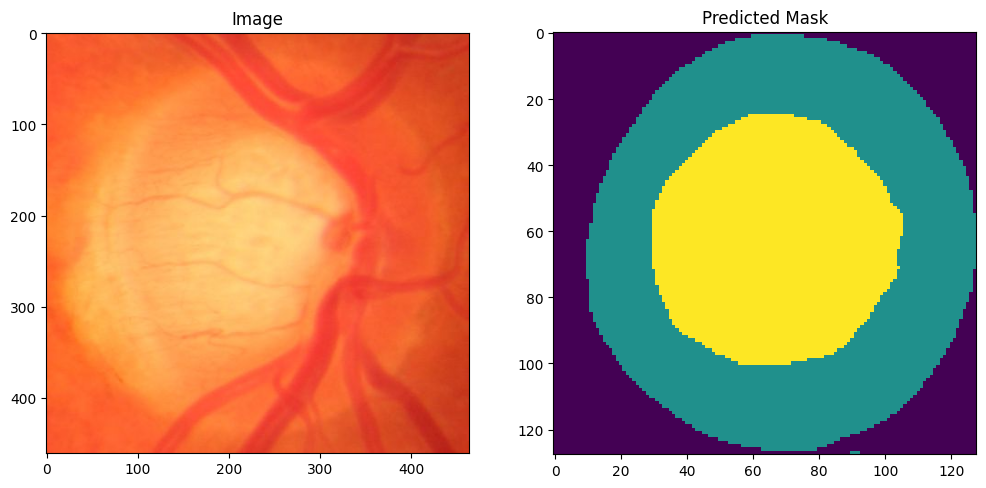

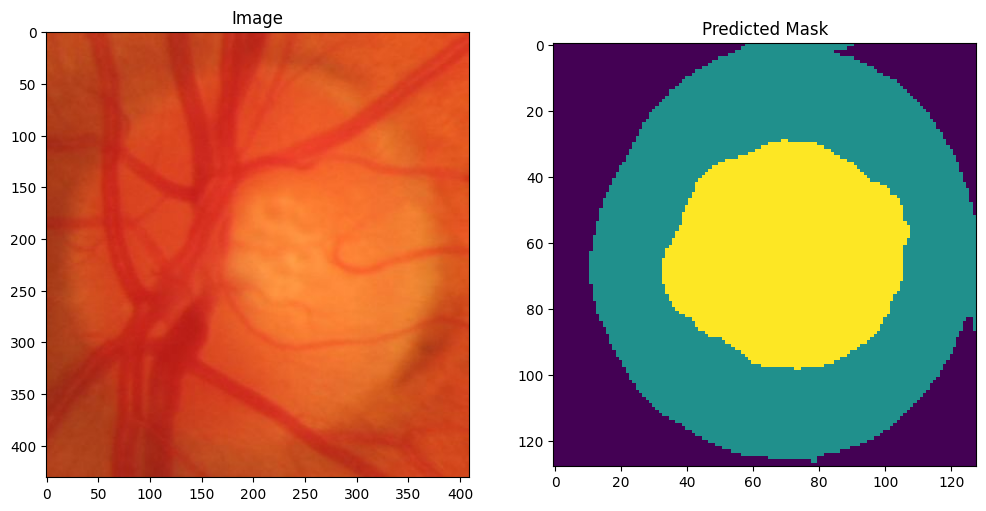

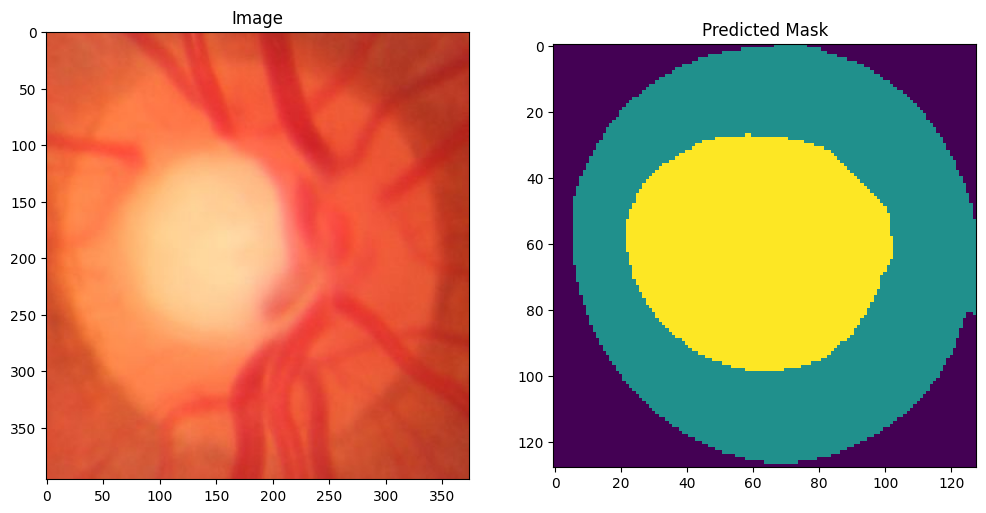

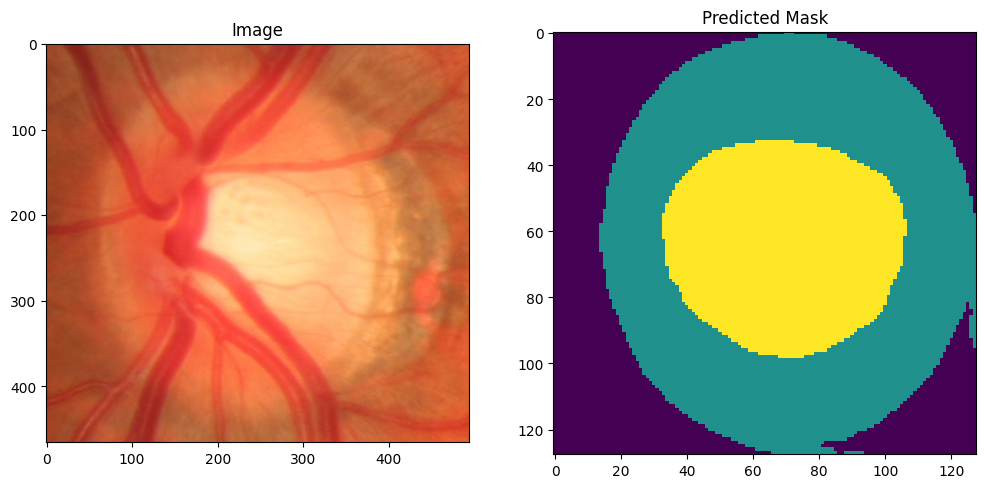

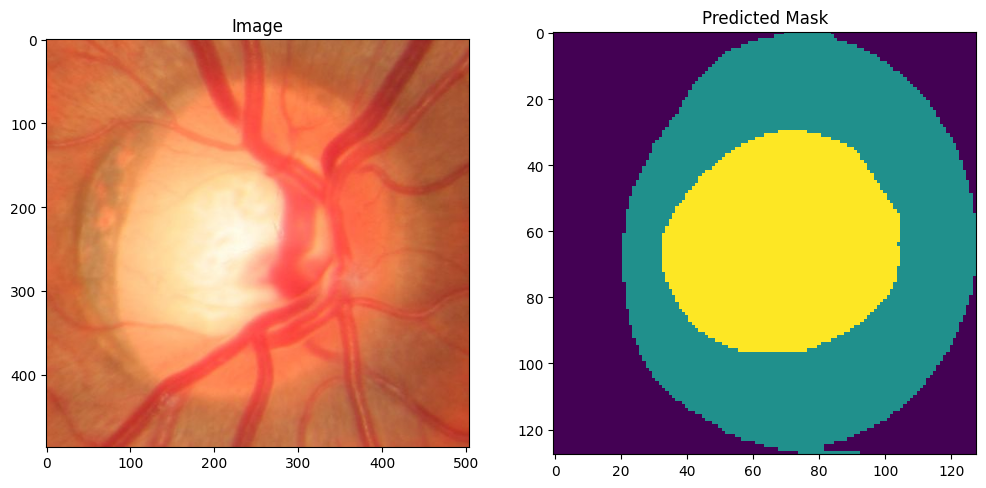

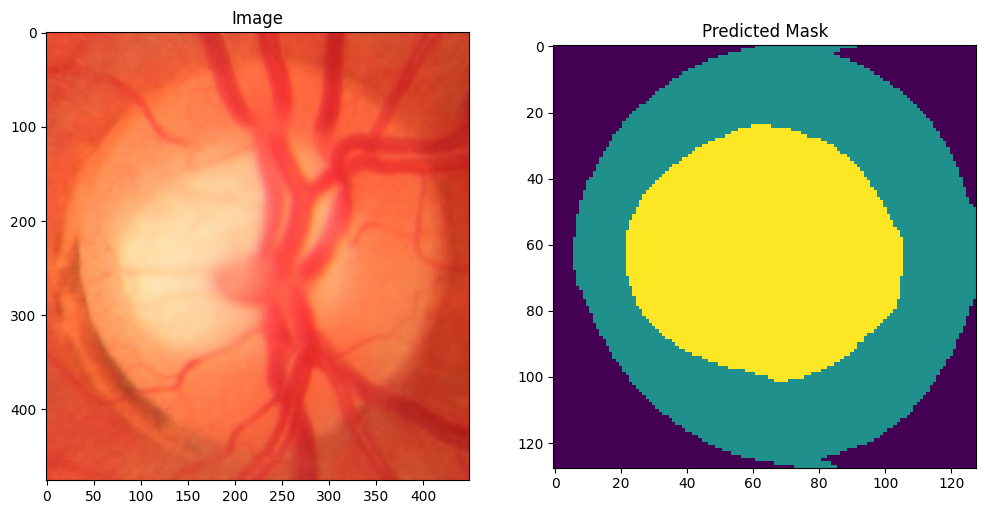

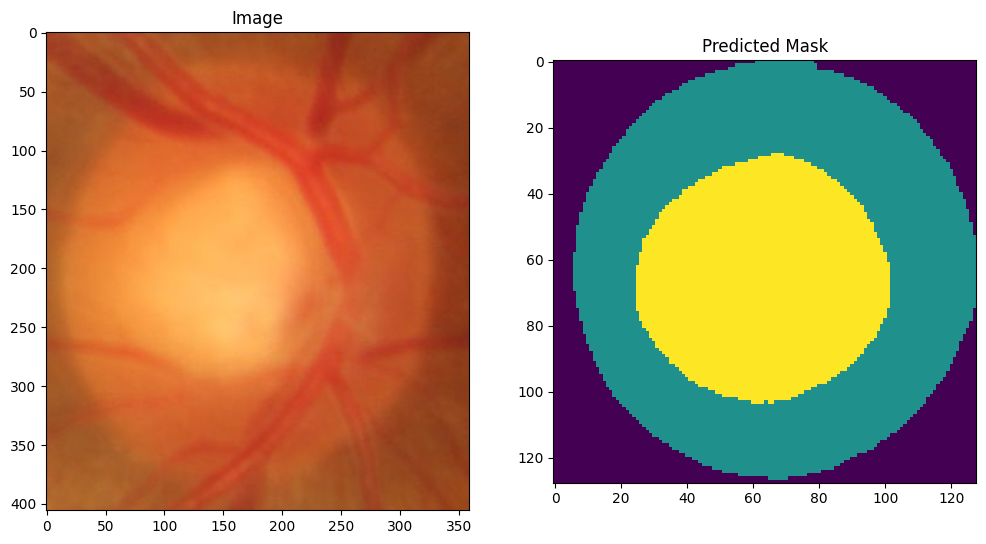

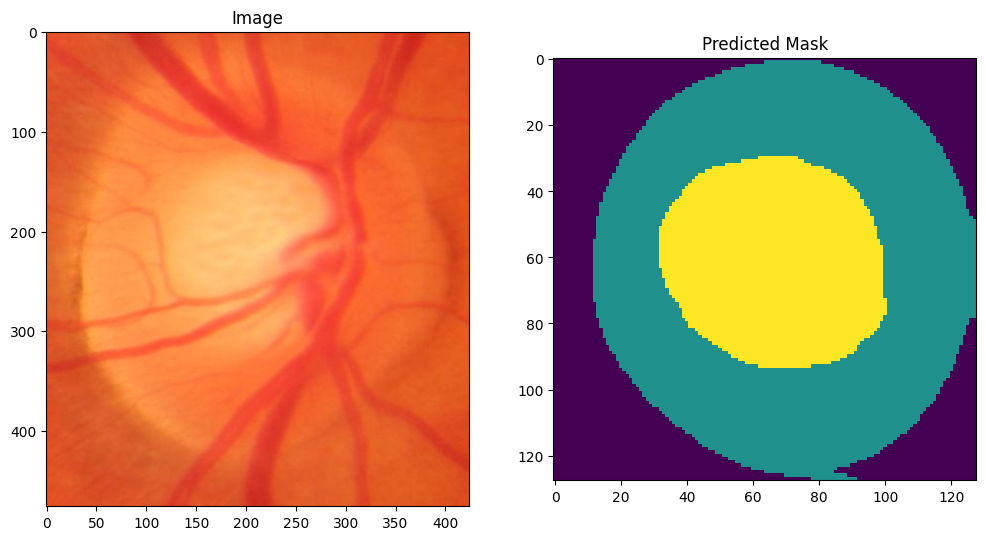

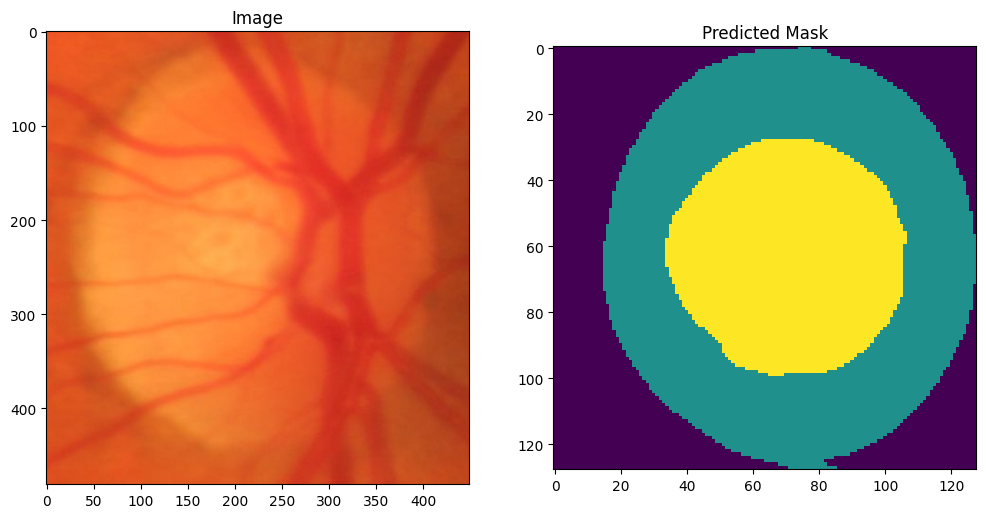

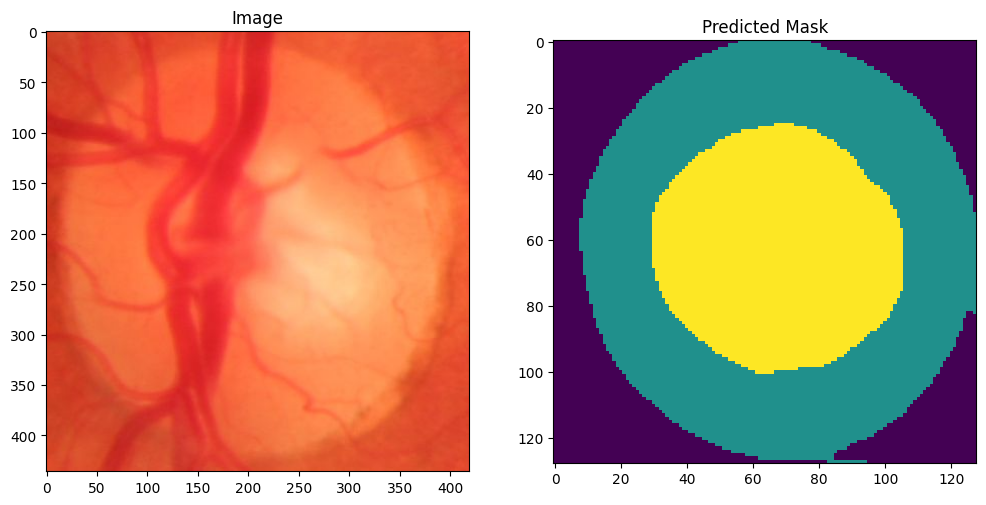

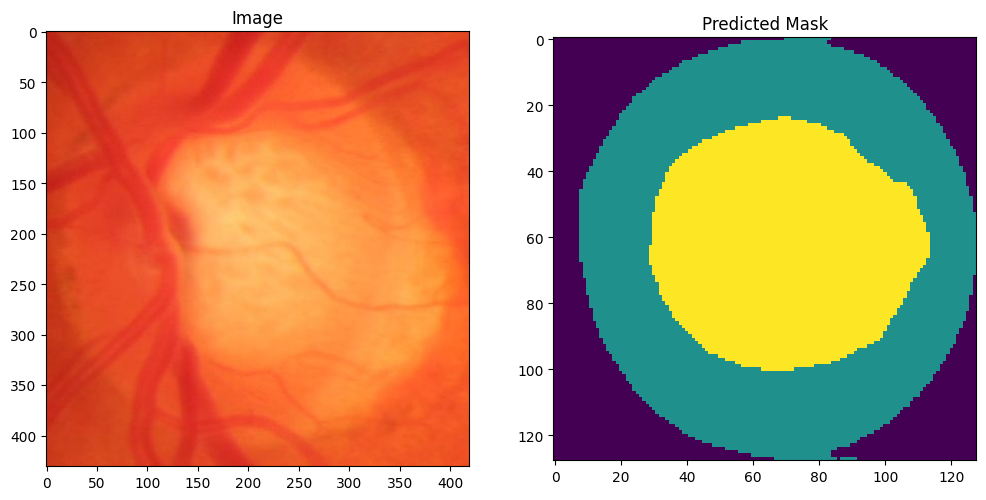

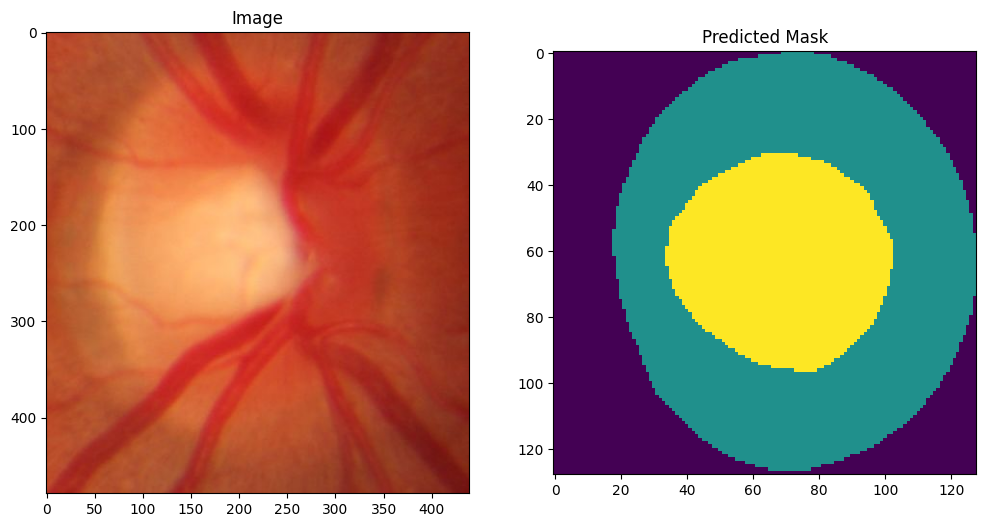

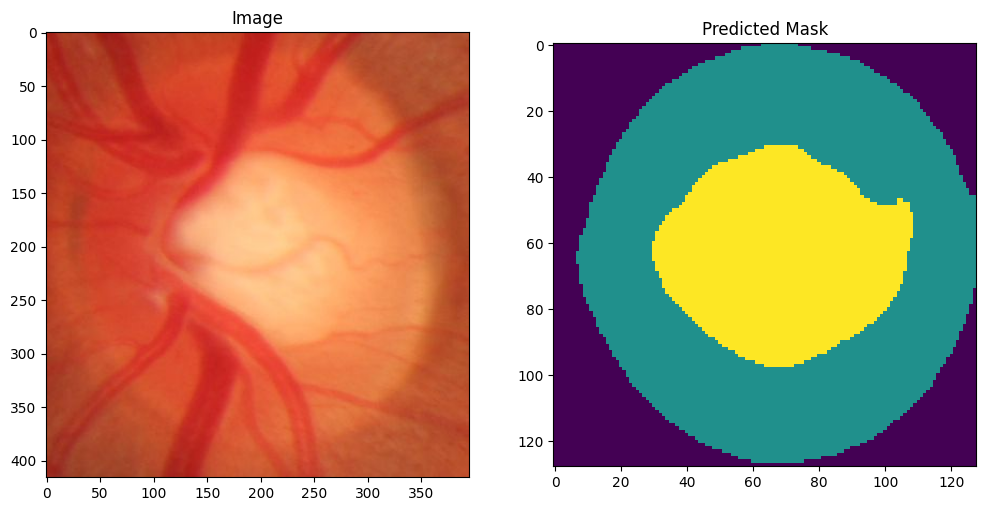

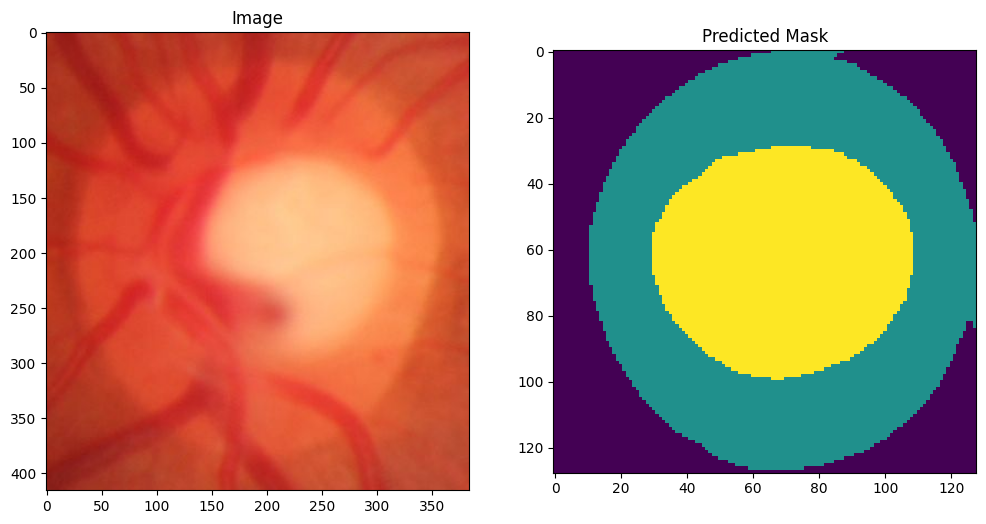

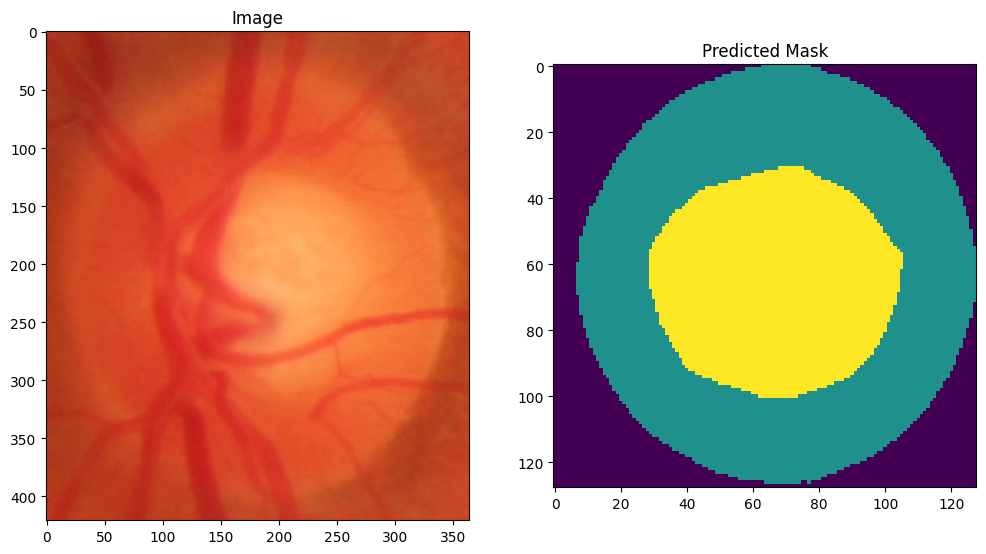

In [ ]:
# Import necessary libraries
from keras.models import load_model
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the trained model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/Saved_model/Segmentation_UNET_Resnet34_ORIGA&RIMONEDL_with_Aug_V2_2040_without_denoising_Epoch_50_batch_16.hdf5', compile=False)

# Load the new dataset
new_image_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/Project Implementation/HRF_Data cleaning/HRF_Cropped/normal/*.jpg")
new_images = [cv2.imread(image, 1) for image in new_image_names]

# Apply resize
new_width = 128
new_height = 128
dim = (new_width, new_height)
resized_images = [cv2.resize(image, dim, interpolation=cv2.INTER_AREA) for image in new_images]

# Preprocess the new images
new_image_dataset = np.array(resized_images)
new_image_dataset = new_image_dataset / 255.

# Make predictions on the new dataset
new_predictions = model.predict(new_image_dataset)
new_predictions_argmax = np.argmax(new_predictions, axis=3)

# Save the predicted masks with the same name as the original images
output_path = "/content/drive/MyDrive/Colab Notebooks/Project Implementation/HRF_Data cleaning/HRF_after_segmentation/normal/"
for i, prediction in enumerate(new_predictions_argmax):
    image_name = os.path.basename(new_image_names[i])
    mask_name = os.path.splitext(image_name)[0] + "_mask.png"
    #cv2.imwrite(output_path + mask_name, prediction)

# Visualize some images with their corresponding masks
num_images_to_visualize = 15
for i in range(num_images_to_visualize):
    plt.figure(figsize=(12, 8))
    plt.subplot(121)
    plt.title('Image')
    plt.imshow(cv2.cvtColor(new_images[i],cv2.COLOR_BGR2RGB)) #I add here
    plt.subplot(122)
    plt.title('Predicted Mask')
    plt.imshow(new_predictions_argmax[i])
    plt.show()

